## Is There Gender Bias in Graduate School Admissions?
<p> Gender inequality is visible on graduate school campuses till date. Is the application process biased? Was it always biased?<p> 

<p>This dataset from 1973 provides a glimpse into the admission process in different departments at UC Berkeley. Here, we explore data from six largest departments to see if the admission process favored a particular gender.</p>


In [ ]:
# Load UCBAdmissions dataset
data(UCBAdmissions)

# Print dataset to console
print(UCBAdmissions)

# Load broom package
library(broom)

# Convert UCBAdmissions to tidy format
ucb_tidy <- tidy(UCBAdmissions)

# Print tidy dataset to console
print(ucb_tidy)

, , Dept = A

          Gender
Admit      Male Female
  Admitted  512     89
  Rejected  313     19

, , Dept = B

          Gender
Admit      Male Female
  Admitted  353     17
  Rejected  207      8

, , Dept = C

          Gender
Admit      Male Female
  Admitted  120    202
  Rejected  205    391

, , Dept = D

          Gender
Admit      Male Female
  Admitted  138    131
  Rejected  279    244

, , Dept = E

          Gender
Admit      Male Female
  Admitted   53     94
  Rejected  138    299

, , Dept = F

          Gender
Admit      Male Female
  Admitted   22     24
  Rejected  351    317

# A tibble: 24 x 4
   Admit    Gender Dept      n
   <chr>    <chr>  <chr> <dbl>
 1 Admitted Male   A       512
 2 Rejected Male   A       313
 3 Admitted Female A        89
 4 Rejected Female A        19
 5 Admitted Male   B       353
 6 Rejected Male   B       207
 7 Admitted Female B        17
 8 Rejected Female B         8
 9 Admitted Male   C       120
10 Rejected Male   C       205
# .

## Acceptance rate for men and women

In [ ]:
# Load the dplyr library
library(dplyr)

# Aggregate over department
ucb_tidy_aggregated <- ucb_tidy %>% 
  group_by(Admit, Gender) %>% 
  summarize(n = sum(n)) %>% 
  ungroup() %>% 
  group_by(Gender) %>% 
  mutate(prop = n / sum(n)) %>% 
  filter(Admit == "Admitted")

# Print aggregated dataset
print(ucb_tidy_aggregated)

# A tibble: 2 x 4
# Groups:   Gender [2]
  Admit    Gender     n  prop
  <chr>    <chr>  <dbl> <dbl>
1 Admitted Female   557 0.304
2 Admitted Male    1198 0.445


## Visualizing acceptance rate
<p>Overall, <strong>44.5% of male applicants</strong> were accepted into Berkeley, as opposed to <strong>30.4% of female applicants</strong>. 

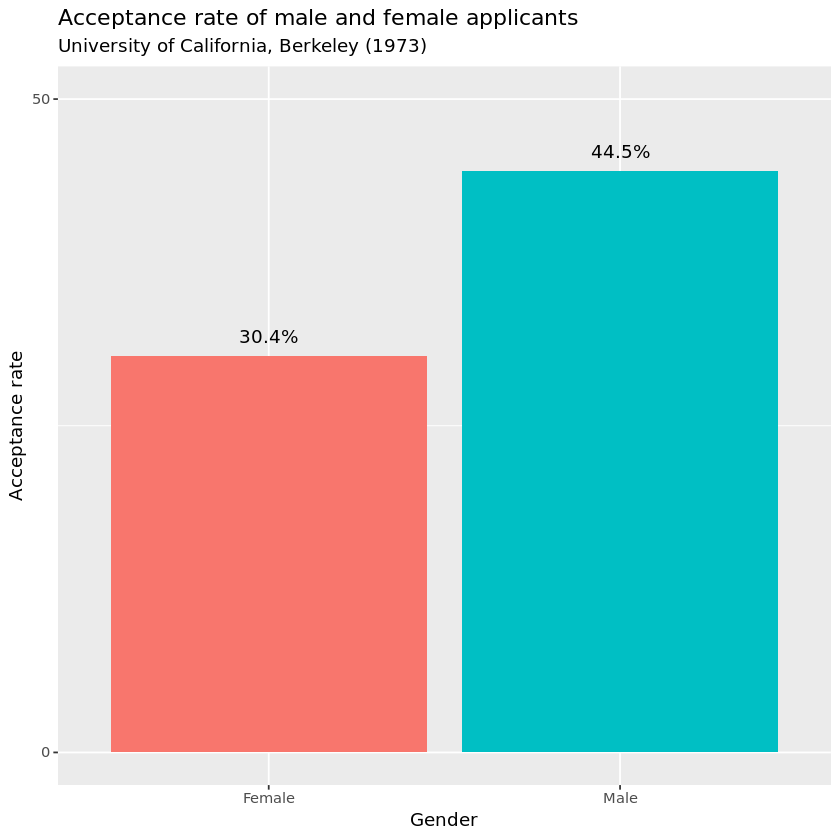

In [19]:
# Load the ggplot2 and scales packages
library(ggplot2)
library(scales)

# Prepare the bar plot
gg_bar <- ucb_tidy_aggregated %>% 
    ggplot(aes(x = Gender, y = prop, fill = Gender)) +
    geom_col() +
    geom_text(aes(label = percent(prop)), vjust = -1) +
    labs(title = "Acceptance rate of male and female applicants",
         subtitle = "University of California, Berkeley (1973)",
         y = "Acceptance rate") +
    scale_y_continuous(breaks = c(0,0.5), labels = c("0","50"), limits = c(0,0.5)) +
    guides(fill = FALSE) 

# Print the bar plot
print(gg_bar) 

## Determining acceptance rates across the departments
<p>The bar plot shows that a higher proportion of men were accepted than women. However, is this true across all departments? </p>


# A tibble: 12 x 5
# Groups:   Gender, Dept [12]
   Admit    Gender Dept      n   prop
   <chr>    <chr>  <chr> <dbl>  <dbl>
 1 Admitted Male   A       512 0.621 
 2 Admitted Female A        89 0.824 
 3 Admitted Male   B       353 0.630 
 4 Admitted Female B        17 0.68  
 5 Admitted Male   C       120 0.369 
 6 Admitted Female C       202 0.341 
 7 Admitted Male   D       138 0.331 
 8 Admitted Female D       131 0.349 
 9 Admitted Male   E        53 0.277 
10 Admitted Female E        94 0.239 
11 Admitted Male   F        22 0.0590
12 Admitted Female F        24 0.0704


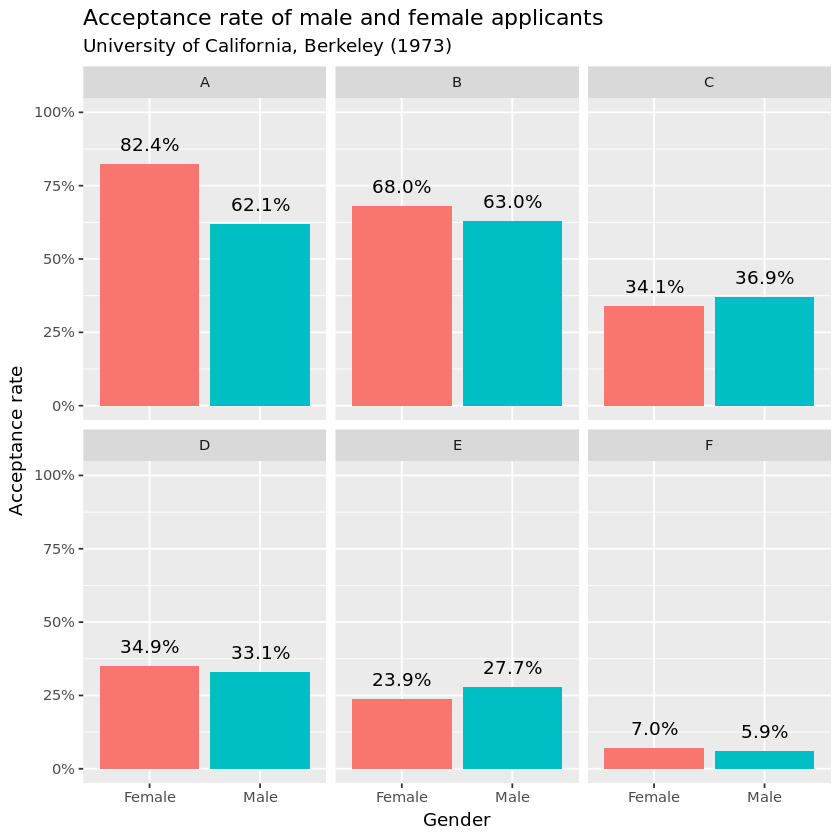

In [21]:
# Calculate acceptance/rejection rate
ucb_by_dept <- ucb_tidy %>% 
    group_by(Gender, Dept) %>% 
    mutate(prop = n / sum(n)) %>% 
    filter(Admit == "Admitted")

# Print the dataset
print(ucb_by_dept)

# Prepare the bar plot for each department
gg_bar_faceted <- ucb_by_dept %>% 
  ggplot(aes(Gender, prop, fill = Gender)) +
  geom_col() +
  geom_text(aes(label = percent(prop)), vjust = -1) +
  labs(title = "Acceptance rate of male and female applicants",
       subtitle = "University of California, Berkeley (1973)",
       y = "Acceptance rate") +
  scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
  facet_wrap(~Dept) +
  guides(fill = FALSE)

# Print the bar plot for each department
print(gg_bar_faceted)

## 5. Alternative explanations
<p>Now that we have separated out our analysis by department, the interpretation has changed rather dramatically. Although men were indeed more likely to be admitted into Departments C and E, women were more likely to be admitted into all other departments. So what's really going on here?</p>
<p>If you turn your attention to the first two plots, you can see that Department A and B were quite easy to get into. However, relatively few women applied to these departments – only 108 women applied to Department A, as opposed to 825 men!</p>
<p>At this stage, we can hypothesise that the effect of gender on acceptance is null when you control for department. We can test that hypothesis using <strong>binary logistic regression</strong>, but first we need to de-aggregate the dataset so that each row represents one student. That should leave us with 4,526 rows – one row for each student who applied to Berkeley that year.</p>

In [23]:
# Define function that repeats each row in each column n times
multiply_rows <- function(column, n) {
  rep(column, n)
}

# Create new de-aggregated data frame using the multiply_rows function
ucb_full <- data.frame(Admit = multiply_rows(ucb_tidy$Admit, ucb_tidy$n),
                      Gender = multiply_rows(ucb_tidy$Gender, ucb_tidy$n),
                      Dept = multiply_rows(ucb_tidy$Dept, ucb_tidy$n))

# Check the number of rows equals the number of students
nrow(ucb_full)

[1] 4526

## 6. Binary logistic regression: part i
<p>The data is now in the right format for us to do some hypothesis testing. Great! But first let's try to predict admittance using gender alone. We will use the built-in <code>glm()</code> function to fit a generalised linear model, making sure to set <code>family = "binomial"</code> because the outcome variable is binary (<code>Admitted</code> or <code>Rejected</code>).</p>
<p>By default, <code>Admit</code> is coded such that <code>Admitted</code> is level 1 and <code>Rejected</code> is level 2 (because of their alphabetical order). Since <code>glm()</code> will assume that level 2 represents 'success', we will reverse the coding of <code>Admit</code> so we are predicting the probability of admittance rather than rejection.</p>
<p>To change the coding of a variable, you can use the <code>fct_relevel()</code> function from the <code>forcats</code> package.</p>

In [25]:
# Load the forcats library
library(forcats)

# Reverse the coding of the Admit variable
ucb_full$Admit <- fct_relevel(ucb_full$Admit, levels = c("Rejected", "admitted"))

# Run the regression
glm_gender <- glm(Admit ~ Gender, data = ucb_full, family = "binomial")

# Summarize the results
summary(glm_gender)

Warning message:
"Outer names are only allowed for unnamed scalar atomic inputs"Warning message:
"Unknown levels in `f`: admitted"


Call:
glm(formula = Admit ~ Gender, family = "binomial", data = ucb_full)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0855  -1.0855  -0.8506   1.2722   1.5442  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.83049    0.05077 -16.357   <2e-16 ***
GenderMale   0.61035    0.06389   9.553   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6044.3  on 4525  degrees of freedom
Residual deviance: 5950.9  on 4524  degrees of freedom
AIC: 5954.9

Number of Fisher Scoring iterations: 4


## 7. Binary logistic regression: part ii
<p>Sure enough, when you predict the probability of admission as a function of gender alone, the effect is statistically significant (p &lt; 0.01). Specifically, you are <code>exp(0.61035) = 1.84</code> times more likely to be admitted if you are a man. However, what happens if we control for department?</p>

In [27]:
# Run the regression, including Dept as an explanatory variable
glm_genderdept <- glm(Admit ~ Gender + Dept, data = ucb_full, family = "binomial")

# Summarize the results
summary(glm_genderdept)


Call:
glm(formula = Admit ~ Gender + Dept, family = "binomial", data = ucb_full)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4773  -0.9306  -0.3741   0.9588   2.3613  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.68192    0.09911   6.880 5.97e-12 ***
GenderMale  -0.09987    0.08085  -1.235    0.217    
DeptB       -0.04340    0.10984  -0.395    0.693    
DeptC       -1.26260    0.10663 -11.841  < 2e-16 ***
DeptD       -1.29461    0.10582 -12.234  < 2e-16 ***
DeptE       -1.73931    0.12611 -13.792  < 2e-16 ***
DeptF       -3.30648    0.16998 -19.452  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6044.3  on 4525  degrees of freedom
Residual deviance: 5187.5  on 4519  degrees of freedom
AIC: 5201.5

Number of Fisher Scoring iterations: 5


## 8. Behold Simpson's paradox
<p>Finally, we can see Simpson's paradox at play – when you control for the effect of department on the probability of admission, the effect of gender disappears. In fact, it even reverses, suggesting that – controlling for department – you were actually more likely to be admitted as a woman! However, this effect is not statistically significant (p &gt; 0.05), so we conclude that there was not a campus-wide bias against applicants of either gender in 1973.</p>
<p>That said, individual departments often handle their own admissions processes, so it is plausible that bias exists in one department but not another. Let's take a look at Department A, where 82.4% of women were admitted but only 62.1% of men. Is the difference statistically significant?</p>

In [29]:
# Filter for Department A
dept_a <- ucb_full %>%
filter(Dept == "A")

# Run the regression
glm_gender_depta <- glm(Admit ~ Gender, data = dept_a, family = "binomial")

# Summarize the results
summary(glm_gender_depta)


Call:
glm(formula = Admit ~ Gender, family = "binomial", data = dept_a)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8642  -1.3922   0.9768   0.9768   0.9768  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.5442     0.2527   6.110 9.94e-10 ***
GenderMale   -1.0521     0.2627  -4.005 6.21e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1214.7  on 932  degrees of freedom
Residual deviance: 1195.7  on 931  degrees of freedom
AIC: 1199.7

Number of Fisher Scoring iterations: 4


## 9. Bias or discrimination?
<p>Well then! If we take Department A in isolation, we find there is a statistically significant bias in favour of women. So does that mean that the department discriminated against men?</p>
<p>Not necessarily. After all, the bias might exist simply because the female applicants to Department A were better qualified that year. In their article dealing with this issue, Bickel, Hammel &amp; O'Connell (1975) define discrimination as "the exercise of decision influenced by the sex of the applicant when that is immaterial to the qualifications for entry". Since we do not have any data on the respective qualifications of the candidates, we cannot say whether any gender bias in their admissions process amounted to discrimination.</p>
<p>Although now more than 40 years old, the Berkeley problem is a useful reminder about the dangers of aggregation and omitted variable bias, especially in relation to matters of such legal and ethical importance as discrimination. Where bias does exist – as it does in the case of Department A – it is always worth considering whether there are any other factors that could explain the discrepancy.</p>

In [31]:
# Define bias
bias <- "a pattern of association between a particular decision and a particular sex of applicant, of sufficient strength to make us confident that it is unlikely to be the result of chance alone"

# Define discrimination
discrimination <- "the exercise of decision influenced by the sex of the applicant when that is immaterial to the qualifications for entry."

# Is bias equal to discrimination?
bias == discrimination

[1] FALSE